# <center>哪种广告的效果更好（A/B测试） </center>

# 1 背景 

一款名为《黑猫拼图》的游戏，每月都会在游戏中展开一次促销活动，但是和该公司的其他应用的促销活动相比，该游戏促销活动的购买率较低。通过调查购买率低的原因，发现问题可能出现在促销活动的广告上。于是准备了两种不同的广告，来验证哪种广告能带来更高的购买率，那么应该如何进行比较？

# 2 现状和预期 

- **现状：《黑猫拼图》游戏的促销活动购买率较低。**
- **前提：和该公司其他应用的促销活动相比。**
- **预期：弄清购买率较低的原因，并确保和其他应用的促销活动有一样的购买率。**

# 3 发现问题 

基于应用的不同，从宏观的角度来思考《黑猫拼图》游戏和其他应用促销活动的不同，并作出假设：
- **游戏装备促销活动的内容有问题**
    - **促销的游戏装备并不是用户需要的**
    - **促销的打折力度不够，对用户没有太大的吸引力**
- **广告的外观展示有问题**

正对上述第一条假设，通过咨询《黑猫拼图》游戏策划部门得知：
- **促销活动的中的游戏装备或许能够用的上**
- **和其它应用促销活动折扣力度一样，都是打五折，站在顾客的立场来看是很划算的**

通过统计活动期间，促销装备的使用情况，发现这些装备都是用户经常使用的，说明第一条假设中的问题基本不大。
接下来考虑第二条假设，通过咨询《黑猫拼图》游戏市场营销部门得知：
- **游戏促销活动的广告都是由各个应用的设计师负责的，所以广告的质量是参差不齐的**
- **《黑猫拼图》游戏的广告的点击率一直比较低下**

# 4 数据的收集和加工 

基于问题来搜集数据，问题：
- **《黑猫拼图》游戏的广告点击率比其它应用低（事实）**
- **《黑猫拼图》游戏的广告设计由问题（假设）**
- **用点击率高的广告替换当前的广告（解决方案）**

为了完成上述解决方案，需要找到哪种广告更容易被用户点击。但是《黑猫拼图》游戏内的促销广告一直没有变更过，所以缺少可供分析的数据。所以，准备两个广告在游戏内投放，并搜集相关数据：
- **如果采用前后投放比较的方法，则无法排除外部因素的干扰**
- **采用A/B测试的方法，排除外部因素的干扰**

A/B测试的关键：
- **A/B测试中用户的分组必须遵循随机的原则（保证分组后没有男/女等类似的差异）**
- **同时进行多个A/B测试时的陷阱：**
    - **所有A/B测试都采用相同的分组方法：就算产生差异，也不不知道到底时哪组测试导致的**
    - **各组中参与其它测试的用户比例不同：虽然是随机分组，但各组参与其它测试的用户比例不同，也可能出现测试项目意外的条件性差异**

A/B测试的输出日志（一个月）就是需要搜集的数据：
- **ab_test_imp（关于广告曝光次数的信息）**
- **ab_test_goal（关于广告点击次数的信息）**
- **上述两张表中的transaction_id字段（“事务ID”字段，广告曝光时生成的ID号，可以用来合并曝光日志和点击日志）**

## 4.1 数据处理和可视化工具准备 

In [188]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 4.2 数据收集 

In [189]:
# 加载ab_test_imp数据
ab_test_imp = pd.read_csv('./data/ch5/section5-ab_test_imp.csv')
ab_test_imp.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id
0,2013-10-01,game-01,sales_test,B,36703,25622
1,2013-10-01,game-01,sales_test,A,44339,25623
2,2013-10-01,game-01,sales_test,B,32087,25624
3,2013-10-01,game-01,sales_test,B,10160,25625
4,2013-10-01,game-01,sales_test,B,46113,25626


In [190]:
# 加载ab_test_goal数据
ab_test_goal = pd.read_csv('./data/ch5/section5-ab_test_goal.csv')
ab_test_goal.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id
0,2013-10-01,game-01,sales_test,B,15021,25638
1,2013-10-01,game-01,sales_test,B,351,25704
2,2013-10-01,game-01,sales_test,B,8276,25739
3,2013-10-01,game-01,sales_test,B,1230,25742
4,2013-10-01,game-01,sales_test,B,17471,25743


## 4.3 数据加工 

为了方便A/B测试，需要将上面两份日志合并起来。并新增一个**click字段**来标记该广告是否被点击。

### 4.3.1 合并日志 

因为广告曝光不一定点击，但是点击一定曝光，所以ab_test_goal中的transaction_id是ab_test_imp中transaction_id的子集。为了能够计算点击率（**点击次数/曝光次数**）,将ab_test_imp和ab_test_goal以transaction_id作为key进行**左连接**：

In [191]:
ab_test_merge = pd.merge(ab_test_imp, 
                         ab_test_goal, 
                         how='left',
                         left_on=ab_test_imp.transaction_id, 
                         right_on=ab_test_goal.transaction_id, 
                         suffixes=('', '_g'))
ab_test_merge.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id,log_date_g,app_name_g,test_name_g,test_case_g,user_id_g,transaction_id_g
0,2013-10-01,game-01,sales_test,B,36703,25622,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-10-01,game-01,sales_test,A,44339,25623,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-10-01,game-01,sales_test,B,32087,25624,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-10-01,game-01,sales_test,B,10160,25625,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-10-01,game-01,sales_test,B,46113,25626,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
ab_test_merge_backup = ab_test_merge.sort_values(by='transaction_id')
ab_test_merge_backup.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id,log_date_g,app_name_g,test_name_g,test_case_g,user_id_g,transaction_id_g
2749,2013-10-02,game-01,sales_test,A,49017,1,NaN,NaN,NaN,NaN,NaN,NaN
2750,2013-10-02,game-01,sales_test,B,49018,2,NaN,NaN,NaN,NaN,NaN,NaN
2751,2013-10-02,game-01,sales_test,A,44338,3,NaN,NaN,NaN,NaN,NaN,NaN
2752,2013-10-02,game-01,sales_test,A,44339,4,NaN,NaN,NaN,NaN,NaN,NaN
2753,2013-10-02,game-01,sales_test,A,28598,5,NaN,NaN,NaN,NaN,NaN,NaN


### 4.3.2 新增click字段 

为了计算点击率，新增click字段，yes表示点击，反之用no表示。

In [193]:
ab_test_merge['click'] = np.where(ab_test_merge.log_date_g.isnull(), 'no', 'yes')
ab_test_merge.head()

,log_date,app_name,test_name,test_case,user_id,transaction_id,log_date_g,app_name_g,test_name_g,test_case_g,user_id_g,transaction_id_g,click
0,2013-10-01,game-01,sales_test,B,36703,25622,NaN,NaN,NaN,NaN,NaN,NaN,no
1,2013-10-01,game-01,sales_test,A,44339,25623,NaN,NaN,NaN,NaN,NaN,NaN,no
2,2013-10-01,game-01,sales_test,B,32087,25624,NaN,NaN,NaN,NaN,NaN,NaN,no
3,2013-10-01,game-01,sales_test,B,10160,25625,NaN,NaN,NaN,NaN,NaN,NaN,no
4,2013-10-01,game-01,sales_test,B,46113,25626,NaN,NaN,NaN,NaN,NaN,NaN,no


提取transaction_id，log_date，test_case，user_id，click字段，简化分析用表:

In [194]:
ab_test_merge = ab_test_merge.reindex(columns=['transaction_id', 'log_date', 'test_case', 'user_id', 'click'])
ab_test_merge.head()

,transaction_id,log_date,test_case,user_id,click
0,25622,2013-10-01,B,36703,no
1,25623,2013-10-01,A,44339,no
2,25624,2013-10-01,B,32087,no
3,25625,2013-10-01,B,10160,no
4,25626,2013-10-01,B,46113,no


A、B两个测试用例是否被点击的交叉表（**方便后续进行AB用例点击的卡方检验**）：

In [195]:
ab_crosstab = pd.crosstab(index=ab_test_merge.test_case, 
                          columns=ab_test_merge.click,
                          rownames=['测试用例'],
                          colnames=['点击'],
                          values=ab_test_merge.user_id,
                          aggfunc='count',
                          margins=True
                         )
ab_crosstab

点击,no,yes,All
测试用例,,,
A,40592.0,3542.0,44134.0
B,38734.0,5056.0,43790.0
All,79326.0,8598.0,87924.0


# 5 数据分析

计算AB测试用例的点击率：

In [196]:
ab_click = (ab_crosstab.yes/ab_crosstab.All).reset_index(name='点击率')
ab_click.iloc[0:2]

,测试用例,点击率
0,A,0.080256
1,B,0.115460


观察测试用例A和B的点击率，发现A的点击率大约为8%，B的点击率大约为12%。在讨论二者的差异之前，需要对其进行假设检验。**像本例这样，针对两种广告点击情况的差异来进行假设检验，一般采用的是卡方检验**：

In [197]:
four_forms = np.array([ab_crosstab.iloc[0, 0:2].values, ab_crosstab.iloc[1, 0:2].values])
four_forms

array([[ 40592.,   3542.],
       [ 38734.,   5056.]])

In [198]:
stats.chi2_contingency(four_forms)[0:3]

(308.37505289322877, 4.9341396337856319e-69, 1)

结果显示p值=~0，自由度为1，所以有理由拒绝0假设（0假设如何设定[卡方检验](https://blog.csdn.net/sinat_26566137/article/details/80971362?from=singlemessage&isappinstalled=0)）,即A和B的点击率存在统计学上的显著差异。

在确认A和B点击率存在“显著性差异”后，再看这种显著性差异在商业中是否是有意。本例中原广告的点击率为6%，而其它广告的点击率为12%，为了填补该差异，进行了AB测试。通过观察结果，发现广告B的点击率大约达到了12%，基本达到了要求，因此在商业领域里这也是一个有意义的差异。最后，再确认是点击率的时间序列图，如果在时间序列图里面，广告B的点击率始终比广告A的点击率高的话，那就没有问题。如果只是某段时间比广告A高，那就需要考虑其它原因了。

In [199]:
ab_test_merge.head()

,transaction_id,log_date,test_case,user_id,click
0,25622,2013-10-01,B,36703,no
1,25623,2013-10-01,A,44339,no
2,25624,2013-10-01,B,32087,no
3,25625,2013-10-01,B,10160,no
4,25626,2013-10-01,B,46113,no


**根据曝光日期和测试用例进行分组，分别统计AB测试用例的曝光量和点击量，然后计算各测试用例每天的点击率：**

In [200]:
ab_test_merge['click_flag'] = np.where(ab_test_merge.click=='yes', 1, 0)
ab_test_merge.head()

,transaction_id,log_date,test_case,user_id,click,click_flag
0,25622,2013-10-01,B,36703,no,0
1,25623,2013-10-01,A,44339,no,0
2,25624,2013-10-01,B,32087,no,0
3,25625,2013-10-01,B,10160,no,0
4,25626,2013-10-01,B,46113,no,0


In [201]:
ab_test_group = ab_test_merge.groupby(['log_date', 'test_case']).agg({'user_id': 'count', 'click_flag': 'sum'})
ab_test_group.rename(columns={'user_id': '曝光量', 'click_flag': '点击量'}, inplace=True)
ab_test_group.head()

曝光量  点击量
log_date   test_case           
2013-10-01 A          1358   98
           B          1391  176
2013-10-02 A          1370   88
           B          1333  212
2013-10-03 A          1213  170

In [202]:
ab_test_group['点击率'] = ab_test_group['点击量']/ab_test_group['曝光量']
ab_test_group.head()

曝光量  点击量       点击率
log_date   test_case                     
2013-10-01 A          1358   98  0.072165
           B          1391  176  0.126528
2013-10-02 A          1370   88  0.064234
           B          1333  212  0.159040
2013-10-03 A          1213  170  0.140148

In [203]:
ab_click_rate = ab_test_group[['点击率']].unstack().reset_index()
ab_click_rate['log_date'] = pd.to_datetime(ab_click_rate.log_date)
ab_click_rate.head()

log_date       点击率          
test_case                    A         B
0         2013-10-01  0.072165  0.126528
1         2013-10-02  0.064234  0.159040
2         2013-10-03  0.140148  0.150041
3         2013-10-04  0.058514  0.119015
4         2013-10-05  0.035287  0.065637

根据上述数据，分别画出测试用例A和B点击率时间序列图：

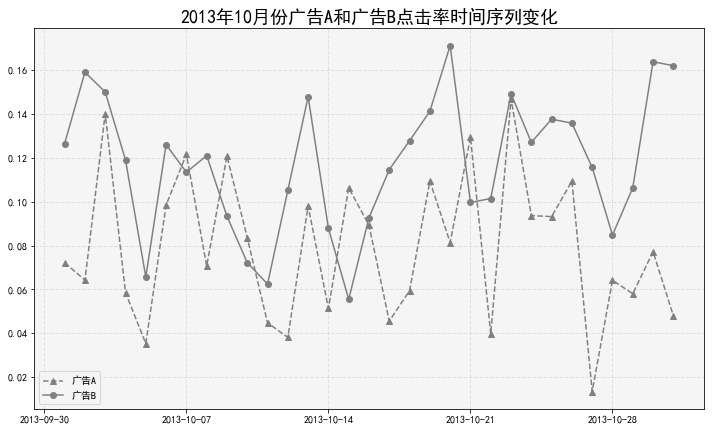

In [205]:
plt.figure(figsize=(12, 7))
plt.gca().set_facecolor('whitesmoke')
plt.plot(ab_click_rate.log_date, ab_click_rate['点击率']['A'], '--^',color='grey', label='广告A')
plt.plot(ab_click_rate.log_date, ab_click_rate['点击率']['B'], '-o', color='gray', label='广告B')
plt.title('2013年10月份广告A和广告B点击率时间序列变化', fontsize=18)
plt.grid(linestyle='--', linewidth=1, alpha=0.3)
plt.legend(facecolor='whitesmoke', loc=3)

由上图可知，广告B的点击率大多数时间都在广告A之上，所以，总的来说，广告B的的效果始终要比广告A好。

# 6 解决策略

根据分析结果可知，广告B的效果要比广告A好，所以将《黑猫拼图》游戏中的促销广告替换为广告B。